In [83]:
import pandas as pd
import numpy as np
np.random.seed(2019)

import re
import sys

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.model_selection import KFold

import seaborn as sns

%matplotlib inline

import xgboost as xgb

import scikitplot as skplt

import arrow

from sklearn.metrics import precision_score, accuracy_score, recall_score
from ml_metrics import rmsle, rmse

import dask.dataframe as dd
from dask.multiprocessing import get



In [89]:
def draw_feature_importances(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), model.feature_importances_[indices],
           color="b", align="center")
    plt.xticks(range(X.shape[1]), [ features[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

# Importing data

In [2]:
train = pd.read_hdf('../input/train_airline_delay.h5')

In [13]:
ttrain = dd.from_pandas(train, npartitions=100)

In [9]:
test = pd.read_csv('../input/test_airline_delay.csv')

In [14]:
ttest = dd.from_pandas(test, npartitions=100)

In [11]:
airports = pd.read_csv('../input/airports.csv')

In [ ]:
carriers = pd.read_csv('../input/carriers.csv')

In [ ]:
airplanes = pd.read_csv('../input/tail_number.csv')

# Constructing features from Airports data

In [17]:
%time ttrain['origin_airport_latitude'] = ttrain.map_partitions(lambda df: df.apply((lambda row: (airports[airports.iata == row['origin']]['lat']).values[0]), axis=1), meta=('float64')).compute(scheduler='multiprocessing')

CPU times: user 28.1 s, sys: 755 ms, total: 28.9 s
Wall time: 1min 52s


In [16]:
ttest['origin_airport_latitude'] = ttest.map_partitions(lambda df: df.apply((lambda row: (airports[airports.iata == row['origin']]['lat']).values[0]), axis=1), meta=('float64')).compute(scheduler='multiprocessing') 

In [18]:
ttrain['origin_airport_longitude'] = ttrain.map_partitions(lambda df: df.apply((lambda row: (airports[airports.iata == row['origin']]['long']).values[0]), axis=1), meta=('float64')).compute(scheduler='multiprocessing')  

In [19]:
ttest['origin_airport_longitude'] = ttest.map_partitions(lambda df: df.apply((lambda row: (airports[airports.iata == row['origin']]['long']).values[0]), axis=1), meta=('float64')).compute(scheduler='multiprocessing')  

In [20]:
%time ttrain['destination_airport_longitude'] = ttrain.map_partitions(lambda df: df.apply((lambda row: (airports[airports.iata == row['destination']]['long']).values[0]), axis=1), meta=('float64')).compute(scheduler='multiprocessing')  

CPU times: user 1min 41s, sys: 7.78 s, total: 1min 48s
Wall time: 2min 7s


In [21]:
ttest['destination_airport_longitude'] = ttest.map_partitions(lambda df: df.apply((lambda row: (airports[airports.iata == row['destination']]['long']).values[0]), axis=1), meta=('float64')).compute(scheduler='multiprocessing')  

In [22]:
ttrain['destination_airport_latitude'] = ttrain.map_partitions(lambda df: df.apply((lambda row: (airports[airports.iata == row['destination']]['lat']).values[0]), axis=1), meta=('float64')).compute(scheduler='multiprocessing')  

In [23]:
ttest['destination_airport_latitude'] = ttest.map_partitions(lambda df: df.apply((lambda row: (airports[airports.iata == row['destination']]['lat']).values[0]), axis=1), meta=('float64')).compute(scheduler='multiprocessing')  

# Adding features with time in minutes

In [24]:
def get_minutes(row):
    s = str(int(row['scheduled_arrival_time']))
    if len(s) < 4: s = (4 - len(s)) * '0' + s
    return (arrow.get(s, 'HHmm') - arrow.get('0000', 'HHmm')).seconds / 60

In [25]:
def get_minutes_departure(row):
    s = str(int(row['scheduled_departure_time']))
    if len(s) < 4: s = (4 - len(s)) * '0' + s
    return (arrow.get(s, 'HHmm') - arrow.get('0000', 'HHmm')).seconds / 60

In [26]:
def get_minutes_elapsed(row):    
    s = str(int(row['scheduled_elapsed_time']))
    if s == '-1': return -1
    if len(s) < 4: s = (4 - len(s)) * '0' + s
    return (arrow.get(s, 'HHmm') - arrow.get('0000', 'HHmm')).seconds / 60

In [27]:
ttrain['scheduled_arrival_time_minutes'] = ttrain.map_partitions(lambda df: df.apply((get_minutes), axis=1), meta=('int64')).compute(scheduler='multiprocessing')  

In [28]:
ttest['scheduled_arrival_time_minutes'] = ttest.map_partitions(lambda df: df.apply((get_minutes), axis=1), meta=('int64')).compute(scheduler='multiprocessing')  

In [29]:
ttest['scheduled_departure_time_minutes'] = ttest.map_partitions(lambda df: df.apply((get_minutes_departure), axis=1), meta=('int64')).compute(scheduler='multiprocessing')  

In [30]:
ttrain['scheduled_departure_time_minutes'] = ttrain.map_partitions(lambda df: df.apply((get_minutes_departure), axis=1), meta=('int64')).compute(scheduler='multiprocessing')  

# Constructing features from Carriers data

In [35]:
def get_mean_delay(row):
    train_carrier = train[train.carrier_id == row['id']]
    length = train_carrier.shape[0]
    return train_carrier['target_delay'].sum()/length

In [36]:
def get_mean_cancels(row):
    train_carrier = train[train.carrier_id == row['id']]
    length = train_carrier.shape[0]
    return train_carrier['is_cancelled'].sum()/length

In [37]:
carriers['mean_delay'] = carriers[['id']].apply(get_mean_delay, axis=1)

In [38]:
carriers['mean_cancels'] = carriers[['id']].apply(get_mean_cancels, axis=1)

In [39]:
def get_carrier_delay(row):
    return (carriers[carriers.id == row['carrier_id']]['mean_delay']).values[0]

In [40]:
def get_carrier_cancels(row):
    return (carriers[carriers.id == row['carrier_id']]['mean_cancels']).values[0]

In [41]:
ttrain['carrier_delay'] = ttrain.map_partitions(lambda df: df.apply((get_carrier_delay), axis=1), meta=('int64')).compute(scheduler='multiprocessing')  

In [42]:
ttest['carrier_delay'] = ttest.map_partitions(lambda df: df.apply((get_carrier_delay), axis=1), meta=('int64')).compute(scheduler='multiprocessing')  

In [43]:
ttrain['carrier_cancels'] = ttrain.map_partitions(lambda df: df.apply((get_carrier_cancels), axis=1), meta=('int64')).compute(scheduler='multiprocessing')  

In [44]:
ttest['carrier_cancels'] = ttest.map_partitions(lambda df: df.apply((get_carrier_cancels), axis=1), meta=('int64')).compute(scheduler='multiprocessing')  

# Constructing features from Airplanes data

In [46]:
global_cancels = np.mean(train['is_cancelled'])

In [47]:
global_mean = np.mean(train['target_delay'])

In [48]:
def get_mean_airplane_delay(row):
    train_carrier = train[train.tail_number == row['id']]
    length = train_carrier.shape[0]
    if length == 0: return global_mean
    local_mean = train_carrier['target_delay'].sum()/length
    return (length * local_mean + 100 * global_mean)/(length + 100)

In [49]:
def get_mean_airplane_cancels(row):
    train_carrier = train[train.tail_number == row['id']]
    length = train_carrier.shape[0]
    if length == 0: return global_cancels
    local_mean = train_carrier['is_cancelled'].sum()/length
    return (length * local_mean + 100 * global_mean)/(length + 100)

In [50]:
airplanes['mean_delay'] = airplanes[['id']].apply(get_mean_airplane_delay, axis=1)

In [51]:
airplanes['mean_cancels'] = airplanes[['id']].apply(get_mean_airplane_delay, axis=1)

In [52]:
def get_airplane_delay(row):
    lista = (airplanes[airplanes.id == row['tail_number']]['mean_delay']).values
    if len(lista) > 0:
        return lista[0]
    return global_mean
    

In [53]:
def get_airplane_cancels(row):
    lista = (airplanes[airplanes.id == row['tail_number']]['mean_cancels']).values
    if len(lista) > 0:
        return lista[0]
    return global_cancels

In [54]:
ttrain['airplane_delay'] = ttrain.map_partitions(lambda df: df.apply((get_airplane_delay), axis=1), meta=('int64')).compute(scheduler='multiprocessing')  

In [55]:
ttest['airplane_delay'] = ttest.map_partitions(lambda df: df.apply((get_airplane_delay), axis=1), meta=('int64')).compute(scheduler='multiprocessing')  

In [56]:
ttrain['airplane_cancels'] = ttrain.map_partitions(lambda df: df.apply((get_airplane_cancels), axis=1), meta=('int64')).compute(scheduler='multiprocessing')  

In [57]:
ttest['airplane_cancels'] = ttest.map_partitions(lambda df: df.apply((get_airplane_cancels), axis=1), meta=('int64')).compute(scheduler='multiprocessing')  

In [58]:
airplanes = airplanes[airplanes['id'].notnull()]

In [59]:
airplanes = airplanes.fillna(-1)

In [62]:
airplanes['id'] = airplanes['id'].astype('int64')

In [63]:
airplanes['year'] = airplanes['year'].map(lambda x: -1 if x=='None' else x).astype('int64')

In [64]:
def get_year(row):
    years = (airplanes[airplanes.id == row['tail_number']]['year']).values
    if len(years) > 0: return years[0]
    return 1981
        

In [65]:
ttrain['airplane_year'] = ttrain.map_partitions(lambda df: df.apply((get_year), axis=1), meta=('int64')).compute(scheduler='multiprocessing')  

In [66]:
ttest['airplane_year'] = ttest.map_partitions(lambda df: df.apply((get_year), axis=1), meta=('int64')).compute(scheduler='multiprocessing')  

In [67]:
airplanes['engine_type'] = airplanes['engine_type'].astype('str')

In [68]:
airplanes['engine_type'].value_counts()

Turbo-Fan        2883
Turbo-Jet        1429
-1                403
Turbo-Prop        122
Reciprocating      29
Turbo-Shaft         7
4 Cycle             4
None                3
Name: engine_type, dtype: int64

In [69]:
def get_engine(row):
    if row['engine_type'] == 'Turbo-Fan' : return '2'
    elif row['engine_type'] == 'Turbo-Jet': return '1'
    else: return '0'

In [70]:
airplanes['engine_type_encoding'] = airplanes[['engine_type']].apply(get_engine, axis=1)

In [71]:
def get_engine_type(row):
    engine = (airplanes[airplanes.id == row['tail_number']]['engine_type_encoding']).values
    if len(engine) > 0: return engine[0]
    return 0

In [72]:
ttrain['airplane_engine'] = ttrain.map_partitions(lambda df: df.apply((get_engine_type), axis=1), meta=('int64')).compute(scheduler='multiprocessing')  

In [73]:
ttest['airplane_engine'] = ttest.map_partitions(lambda df: df.apply((get_engine_type), axis=1), meta=('int64')).compute(scheduler='multiprocessing')  

# Computing back dataframes from Dask

In [74]:
train = ttrain.compute()

In [75]:
test = ttest.compute()

# Moving some extreme values in features

In [76]:
train['scheduled_elapsed_time_fixed'] = train['scheduled_elapsed_time'].map(lambda x: 10 if x < 0 else x) 

In [77]:
train['scheduled_elapsed_time_fixed'] = train['scheduled_elapsed_time_fixed'].fillna(100)

In [78]:
test['scheduled_elapsed_time_fixed'] = test['scheduled_elapsed_time'].map(lambda x: 10 if x < 10 else x) 

In [79]:
test['scheduled_elapsed_time_fixed'] = test['scheduled_elapsed_time_fixed'].fillna(100)

In [80]:
train['airplane_year'] = train['airplane_year'].map(lambda x : 1981 if x < 100 else x)

In [81]:
test['airplane_year'] = test['airplane_year'].map(lambda x : 1981 if x < 100 else x)

# Training model for 'is_cancelled' feature prediction

In [82]:
feats_c = ['scheduled_arrival_time_minutes', 'scheduled_departure_time_minutes', 'tail_number', 'airplane_year', 'airplane_cancels',
        'year', 'month', 'day_of_month' , 'origin_airport_latitude', 'origin_airport_longitude', 'distance', 'airplane_engine',
         'destination_airport_latitude', 'destination_airport_longitude', 'scheduled_elapsed_time_fixed', 'carrier_cancels']

X = train[feats_c].values
c = train['is_cancelled'].values

model_c = xgb.XGBClassifier(n_estimators=300, max_depth=9, seed=2019, max_features=0.8, n_jobs=30, learning_rate=0.05)

In [84]:
X_train, X_test, c_train, c_test = train_test_split(X, c, test_size=0.3)

%time model_c.fit(X_train, c_train)
%time c_pred = model_c.predict(X_test)

precision_score(c_test, c_pred)

CPU times: user 32min 30s, sys: 14min 57s, total: 47min 28s
Wall time: 3min
CPU times: user 20.2 s, sys: 6.12 s, total: 26.4 s
Wall time: 2.41 s


0.9983420180009475

In [85]:
accuracy_score(c_test, c_pred)

0.9937735002398378

In [86]:
recall_score(c_test, c_pred)

0.677652733118971

In [87]:
train['is_cancelled_pred'] = model_c.predict(train[feats_c].values)

In [88]:
test['is_cancelled_pred'] = model_c.predict(test[feats_c].values)

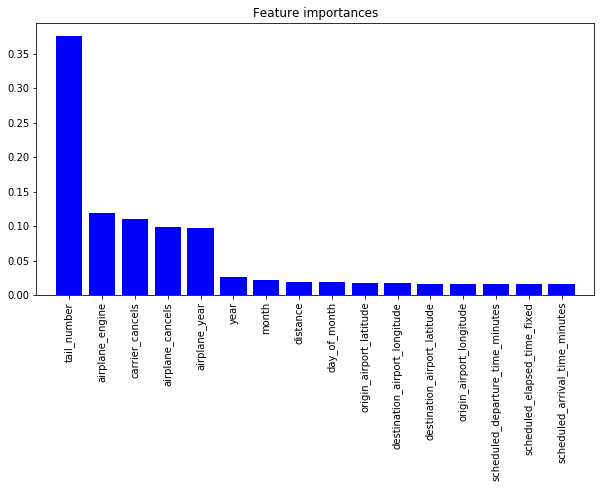

In [90]:
draw_feature_importances(model_c, feats_c)

# Training main model

In [91]:
#Very important: transforming logarithmically the target delay

train['target_delay_log'] = np.log(train['target_delay'] + 1)

In [93]:
feats_153 = ['scheduled_departure_time_minutes', 'carrier_id', 'scheduled_arrival_time_minutes', 'airplane_delay',
        'year', 'month', 'day_of_month' , 'day_of_week', 'origin_airport_latitude', 'origin_airport_longitude', 'carrier_delay',
         'destination_airport_latitude', 'destination_airport_longitude', 'is_cancelled_pred']

X = train[feats_153].values
y = train['target_delay_log'].values

model_153 = xgb.XGBRegressor(n_estimators=1000, max_depth=10, seed=2019, max_features=0.8, n_jobs=50, learning_rate=0.03)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

%time model_153.fit(X_train, y_train)
y_pred_exp = np.exp(model_153.predict(X_test)) - 1
y_pred_exp[y_pred_exp < 0] = 0

y_test_exp = np.exp(y_test) - 1
y_test_exp[y_test_exp < 0] = 0

rmsle(y_test_exp, y_pred_exp)

CPU times: user 2h 18min 30s, sys: 2h 8min 20s, total: 4h 26min 51s
Wall time: 16min 44s


1.5330097616725544

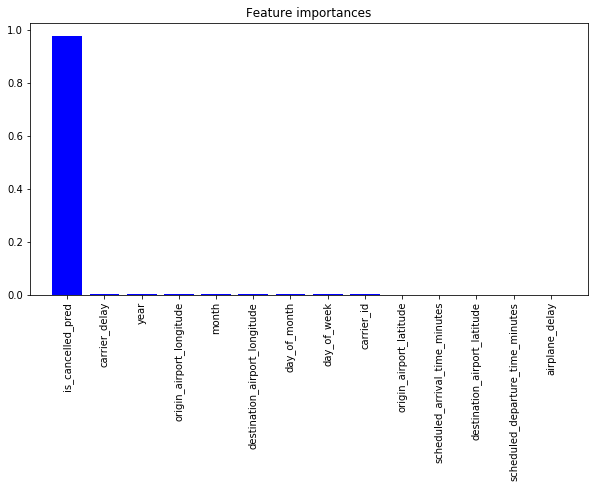

In [97]:
draw_feature_importances(model_153, feats_153)

In [95]:
X_pred = test[feats_153].values

y_pred = np.exp(model_153.predict(X_pred)) - 1
y_pred[y_pred < 0] = 0

In [96]:
test['target_delay'] = y_pred
test[ ['id', 'target_delay'] ].to_csv('../output/submit_model_is_cancelled_delay_and_cancel_means_check.csv', index=False)